# Health Analysis

This notebook considers all the markers of health. We start with a PCA, and then work towards a 3D PCA. Next we look at the statistics.

In [1]:
import os
import sys
from socket import gethostname

# this is for ffmpeg
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/miniconda3/envs/bioinformatics/bin')

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', taxa="family")

## Read the data

In [2]:
encoder_models = 'cluster_gbrfs'; datasource = 'only Bacteria taxa and subsystems'
#encoder_models = 'cluster_gbrfs_eukaryotes'; datasource = 'all taxa and subsystems'
# encoder_models = 'cluster_gbrfs_all'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['Cluster', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['CPAF'] = cluster_assignments['Cluster'].astype(int)
cluster_assignments['Cluster'] = cluster_assignments['Cluster'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)
# I'm going to use CPAF instead of cluster -- Cluster of Phylogeny and Function
pc_df.columns = pc_df.columns.str.replace("Cluster", "CPAF", regex=False)

In [3]:
intcols = ['IP vs OP', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank','Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']

intcol = intcols[1]
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

# 0. Are the metadata values correlated?

First, we encode the antibiotics and IP/OP, and then we use our PCA trick to get a single number for the "Medications Score". Finally, we see if that is correlated.

In [4]:
md = metadata[intcols].dropna(subset=intcols)
# here we encode the IP vs OP and Antibiotics_YN
md['IP vs OP_enc'] = md['IP vs OP'].astype('category').cat.codes
md['Antibiotics_YN_enc'] = md['Antibiotics_YN'].astype('category').cat.codes

reorder = ['IP vs OP', 'IP vs OP_enc', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank','Antibiotics_YN', 'Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
md = md[reorder]

In [5]:
# PCA scaling of the data
pca = PCA(n_components=1)

# separate the columns
antibiotic_cols = ['Antibiotics_YN_enc', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs']
scaled = StandardScaler().fit_transform(md[antibiotic_cols])
tmp = pca.fit_transform(scaled) * -1
md['Medications Score'] = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 100

if False:
    # we don't really need this because it is the same as the FEV1 Ratio Score
    fev_cols = ['IP vs OP_enc', 'FEV1/best FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank']
    scaled = StandardScaler().fit_transform(md[fev_cols])
    md['FEV1 Score'] = pca.fit_transform(scaled)


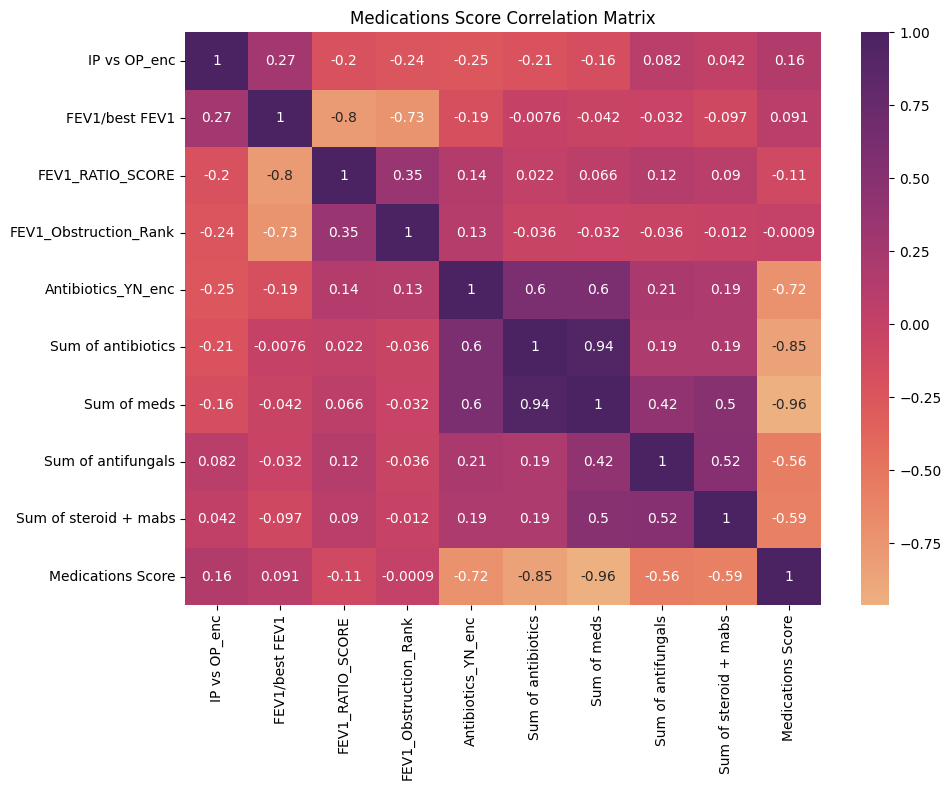

In [10]:
plt.figure(figsize=(10, 8))
md_corr = md.drop(columns=['IP vs OP', 'Antibiotics_YN']).corr()
sns.heatmap(md_corr, annot=True, cmap='flare')
plt.title("Medications Score Correlation Matrix")
plt.tight_layout()
plt.show()

a) IP vs OP; b) FEV1/best FEV1; c) FEV1_RATIO_SCORE; d) FEV1_Obstruction_Rank; e) Antibiotics_YN; f) Sum of antibiotics; g) Sum of meds; h) Sum of antifungals; i) Sum of steroid + mabs; 


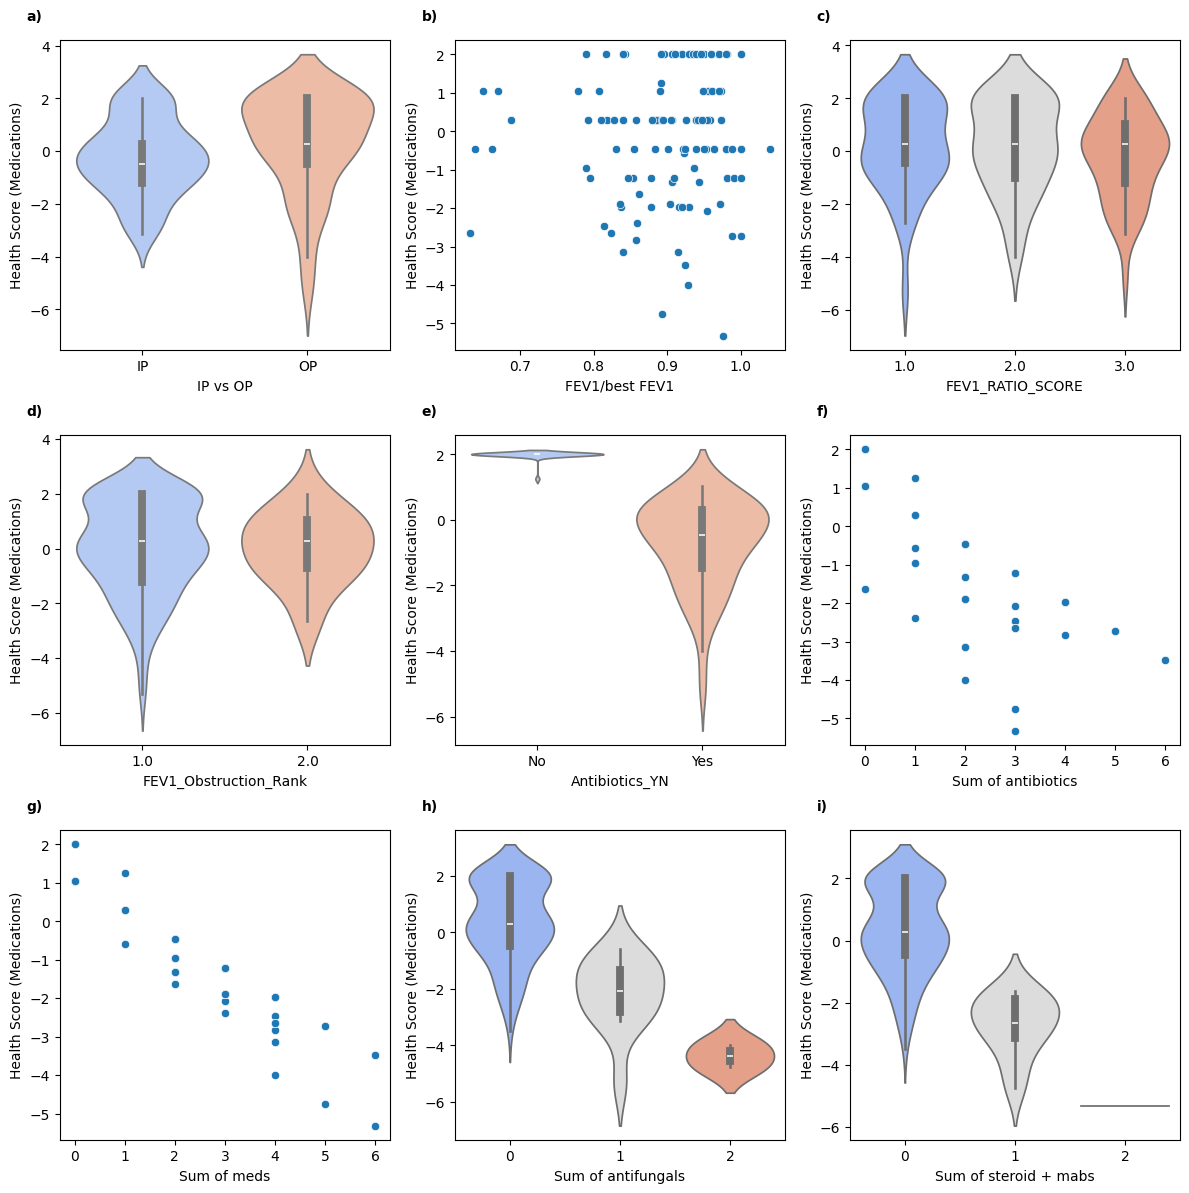

In [7]:
nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
ycol = 'Medications Score'
for i, intcol in enumerate(intcols):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    violins = ['IP vs OP', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Antibiotics_YN', 'Sum of antifungals', 'Sum of steroid + mabs']
    if intcol in violins:
        sns.violinplot(data=md, x=intcol, y=ycol, ax=ax, palette='coolwarm', hue=intcol, legend=False)
    else:
        sns.scatterplot(data=md, x=intcol, y=ycol, ax=ax)

labels = [f"{chr(97+i)})" for i in range(nrows*ncols)]
for ax, label in zip(axes.flat, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {ax.get_xlabel()}", end="; ")
print()

plt.tight_layout()
plt.show()

## Add the new Medications Score to the metadata

In [8]:
intcols

['IP vs OP',
 'FEV1/best FEV1',
 'FEV1_RATIO_SCORE',
 'FEV1_Obstruction_Rank',
 'Antibiotics_YN',
 'Sum of antibiotics',
 'Sum of meds',
 'Sum of antifungals',
 'Sum of steroid + mabs']

In [9]:
intcols += ['Medications Score']
merged_df = pc_df.join(md).dropna(subset=intcols)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

# 1. PCA Analysis of the data

In [10]:
intcol

'Sum of steroid + mabs'

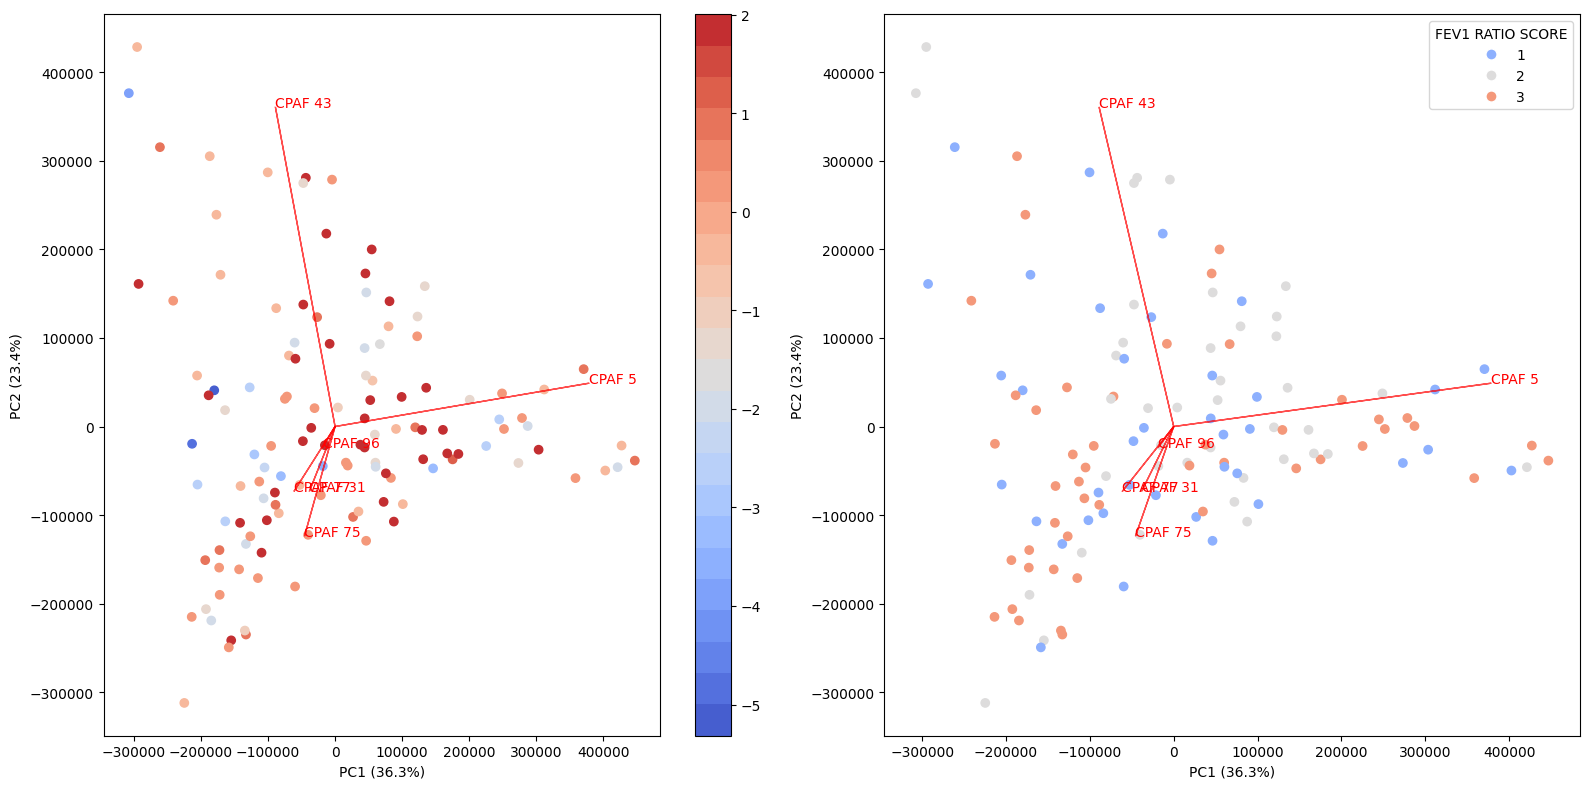

In [11]:
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

"""
le = LabelEncoder()
if intcol == 'FEV1/best FEV1':
    cols = y
else:
    cols = le.fit_transform(y)
"""

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))
cpalette = 'coolwarm'
# Plot PCA scatter, color by metadata
intcol = 'Medications Score'
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
y = md[intcol]

ax_hs = axes[0]
scatter_hs = ax_hs.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=y, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
cbar = fig.colorbar(scatter_hs, ax=ax_hs)
#ax_hs.colorbar(scatter, label=intcol_title)
ax_hs.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax_hs.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

# Plot loadings (top contributing variables)
topN = 6
loadings = pca.components_.T  # shape: (150 variables, 2 PCs)
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables

sep = 400000
for i in top_indices:
    ax_hs.arrow(0, 0, loadings[i, 0]*sep, loadings[i, 1]*sep, color='r', alpha=0.7, head_width=0.1)
    ax_hs.text(loadings[i, 0]*sep, loadings[i, 1]*sep, X.columns[i], color='r', fontsize=10)

intcol = 'FEV1_RATIO_SCORE'
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
y = md[intcol]
ax_fev = axes[1]
scatter_fev = ax_fev.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=y, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))

handles = []
for val in sorted(y.unique()):
    color = scatter_fev.cmap(scatter_fev.norm(val))
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f"{val:.0f}",
                              markerfacecolor=color, markersize=8))
ax_fev.legend(handles=handles, title=intcol_title)

#cbar = fig.colorbar(scatter_fev, ax=ax_fev)
#ax_fev.colorbar(scatter, label=intcol_title)
ax_fev.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax_fev.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

# Plot loadings (top contributing variables)
topN = 6
loadings = pca.components_.T  # shape: (150 variables, 2 PCs)
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables

sep = 400000
for i in top_indices:
    ax_fev.arrow(0, 0, loadings[i, 0]*sep, loadings[i, 1]*sep, color='r', alpha=0.7, head_width=0.1)
    ax_fev.text(loadings[i, 0]*sep, loadings[i, 1]*sep, X.columns[i], color='r', fontsize=10)



#plt.grid(True)
plt.tight_layout()
plt.show()

### Read the cluster virulence data to generate a mesh grid

This data is generated by `virulence_matching.py` and uses several different measures to compare the cluster annotations and the virulence factor database.

In [12]:

# cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence = pd.read_csv(os.path.join(encoder_models, 'cluster_virulence_score_tokenised.tsv.gz'), compression='gzip', sep="\t", index_col=0)
cluster_virulence.index = cluster_virulence.index.str.replace("Cluster", "CPAF", regex=False)
cluster_virulence.sort_values(by='Normalised Jaccard')

,Tokens,Virulence Factors,Intersection,Union,Jaccard Distance,Normalised Jaccard,Frac cluster virulence,Enrichment Score,Normalized Enrichment Score
Cluster,,,,,,,,,
CPAF 90,10,3600,0,3610,0.000000,0.000000,0.000000,-1.000000,-1.000000
CPAF 78,4,3600,0,3604,0.000000,0.000000,0.000000,-1.000000,-1.000000
CPAF 149,13,3600,0,3613,0.000000,0.000000,0.000000,-1.000000,-1.000000
CPAF 70,8,3600,0,3608,0.000000,0.000000,0.000000,-1.000000,-1.000000
CPAF 50,5,3600,0,3605,0.000000,0.000000,0.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...
CPAF 145,57,3600,11,3646,0.003017,0.407519,0.192982,-0.727251,-0.571402
CPAF 131,29,3600,11,3618,0.003040,0.410673,0.379310,-0.463908,-0.302005
CPAF 75,34,3600,14,3620,0.003867,0.522386,0.411765,-0.418039,-0.264254


### Plot a mesh grid using RBF interpolation

In [13]:
intcols

['IP vs OP',
 'FEV1/best FEV1',
 'FEV1_RATIO_SCORE',
 'FEV1_Obstruction_Rank',
 'Antibiotics_YN',
 'Sum of antibiotics',
 'Sum of meds',
 'Sum of antifungals',
 'Sum of steroid + mabs',
 'Health Score (Medications)']

In [14]:
#intcol = 'Medications Score'
intcol = 'FEV1_Obstruction_Rank'
intcol_title = replace_index.sub('', intcol).replace('_', ' ')

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

loading_weight = round(max(pca_result[:, 0]), -5) # this rounds to the nearest 100,000 and could be weird for another value. Probably needs generatlising
loadings = pca.components_.T
x_load, y_load = loadings[:, 0]*loading_weight, loadings[:, 1]*loading_weight

# Get enrichment scores for each variable
es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence', 'Normalised Jaccard', 'Normalised Enrichment Score',
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]

# 3. Create grid
#grid_x, grid_y = np.mgrid[min(x_load)-1:max(x_load)+1:100j, min(y_load)-1:max(y_load)+1:100j]
grid_x, grid_y = np.mgrid[min(pca_result[:, 0])-1:max(pca_result[:, 0])+1:100j, min(pca_result[:, 1])-1:max(pca_result[:, 1])+1:100j]

# 4. RBF interpolation
points = np.column_stack((x_load, y_load))
values = np.array(enrichment_scores)
rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')
x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 100)
y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 100)

xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.column_stack((xx.ravel(), yy.ravel()))
grid_vals = rbf(grid_points)
grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))

# 5. Plot PCA scatter
cpalette = 'coolwarm'
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                      c=cols, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
plt.colorbar(scatter, label=intcol_title)

# 6. Overlay mesh
mesh = plt.scatter(grid_points[:, 0], grid_points[:, 1], c=grid_vals, cmap='coolwarm', alpha=0.1, s=5)

cbar = plt.colorbar(mesh)
cbar.set_label(es)

# 7. Plot loadings arrows
for i in top_indices:
    plt.arrow(0, 0, loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, color='r', alpha=0.7, head_width=0.1)
    plt.text(loadings[i, 0]*loading_weight, loadings[i, 1]*loading_weight, X.columns[i], color='r', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title(f'PCA with {es} Mesh Overlay coloured {intcol_title}')
plt.xlim(min(pca_result[:,0]), max(pca_result[:,0]))
plt.ylim(min(pca_result[:,1]), max(pca_result[:,1]))
plt.grid(False)
plt.tight_layout()
plt.show()

NameError: name 'cols' is not defined

<Figure size 1000x800 with 0 Axes>

# The 3D version

Note that this is a single 3D image. See the HealthPCA-3D noteboook for movies of this!

In [ ]:
intcols = ['IP vs OP', 'Antibiotics_YN', 'Sum of antibiotics', 'Sum of meds', 'Sum of antifungals', 'Sum of steroid + mabs', 'FEV1/best FEV1']

intcol = intcols[2]
intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[intcols]).dropna(subset=intcols)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcols, axis=1)
y = merged_df[intcol]


le = LabelEncoder()
if intcol == 'FEV1/best FEV1':
    cols = y
else:
    cols = le.fit_transform(y)

# 3D PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X)

# Prepare loadings and enrichment
loading_weight_X = round(max(pca_result[:, 0]), -5) 
loading_weight_Y = round(max(pca_result[:, 1]), -5) 
loading_weight_Z = round(max(pca_result[:, 2]), -5) 
loadings = pca.components_.T  # shape: (n_features, 3)
scaling_factor = 5000
x_load, y_load, z_load = loadings[:, 0]*loading_weight_X, loadings[:, 1]*loading_weight_Y, loadings[:, 2]*loading_weight_Z

topN = 6
loading_magnitude = np.sum(loadings**2, axis=1)
top_indices = np.argsort(loading_magnitude)[-topN:]  # Top 5 variables


# Get enrichment scores for each variable
es = 'Normalised Jaccard' # 'Enrichment Score', 'Jaccard Distance', 'Frac cluster virulence', 'Normalised Jaccard', 'Normalised Enrichment Score',
enrichment_scores = [cluster_virulence.loc[col, es] if col in cluster_virulence.index else 0 for col in X.columns]
colors = plt.cm.coolwarm((np.array(enrichment_scores) + 1) / 2)  # Normalize -1 to 1

# 3. RBF interpolation
points = np.column_stack((x_load, y_load, z_load))
values = np.array(enrichment_scores)
rbf = RBFInterpolator(points, values, kernel='thin_plate_spline')

# 4. 3D Grid
x_range = np.linspace(min(pca_result[:,0])-2, max(pca_result[:,0])+2, 30)
y_range = np.linspace(min(pca_result[:,1])-2, max(pca_result[:,1])+2, 30)
z_range = np.linspace(min(pca_result[:,2])-2, max(pca_result[:,2])+2, 30)

xx, yy, zz = np.meshgrid(x_range, y_range, z_range)
grid_points = np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))
grid_vals = rbf(grid_points)
grid_vals = np.clip(grid_vals, min(enrichment_scores), max(enrichment_scores))


In [ ]:
# 5. Plot enrichment as colored scatter mesh
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Enrichment mesh
sc_mesh = ax.scatter(grid_points[:, 0], grid_points[:, 1], grid_points[:, 2], 
                     c=grid_vals, cmap='bwr', alpha=0.1, s=5)

# Sample points
#sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
#                        c=y, cmap=mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique()))))
if categorical_data:
    mycmap = 'tab10'
else:
    mycmap = mcolors.ListedColormap(sns.color_palette(cpalette, len(y.unique())))
sc_samples = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], 
                        c=y, cmap=mycmap)


# Loadings arrows
for i in top_indices:
    ax.quiver(0, 0, 0, 
              x_load[i], y_load[i], z_load[i], 
              color=colors[i], alpha=0.8, arrow_length_ratio=0.05)
    ax.text(x_load[i], y_load[1], z_load[i], X.columns[i], color='r', fontsize=10)

# Axes labels
ax.xaxis.labelpad = -10  # default ~10, so reduce to move closer
ax.yaxis.labelpad = -10
ax.zaxis.labelpad = -10
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title(f'3D PCA with {es} Mesh Overlay colored by {intcol_title}')

# adjust the ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xlim(min(pca_result[:,0])-2, max(pca_result[:,0])+2)
ax.set_ylim(min(pca_result[:,1])-2, max(pca_result[:,1])+2)
ax.set_zlim(min(pca_result[:,2])-2, max(pca_result[:,2])+2)

# Colorbar

if categorical_data:
    handles = []
    for val in sorted(y.unique()):
        label = custom_labels[val]
        color = sc_samples.cmap(sc_samples.norm(val))
        handles.append(plt.Line2D([0], [0], marker='o', color='w', label=label,
                                  markerfacecolor=color, markersize=8))
    ax.legend(handles=handles, title=intcol_title)
else:
    cb2 = fig.colorbar(sc_samples, label=intcol_title, shrink=0.6, aspect=20)
cb = fig.colorbar(sc_mesh, shrink=0.6, aspect=20)
cb.set_label(es)
plt.grid(False)
plt.tight_layout()
plt.show()

# Statistical Analysis

We're using `statsmodels` for some of this, and it completely craps out if there are spaces in the column names, so we start by fixing that.

We initially tried a MANOVA but we have number of variables (150) > number of samples (125) so the stats breaks down :(

In [ ]:
merged_df_clean = merged_df.copy()
merged_df_clean.columns = [col.replace('Cluster', 'CPAF').replace(' ', '_') for col in merged_df_clean.columns]
merged_df_clean

In [ ]:
intcols = ['IP_vs_OP', 'FEV1/best_FEV1', 'Antibiotics_YN', 'Sum_of_antibiotics', 'Sum_of_meds', 'Sum_of_antifungals', 'Sum_of_steroid_+_mabs', 'Health_Score_(Medications)']

intcol = intcols[-1]

# 1. Prepare your features (e.g., first 150 PCs)
X = merged_df_clean.iloc[:, :150].values

# 2. Compute distance matrix (e.g., Euclidean)
dist_matrix = pairwise_distances(X, metric='euclidean')

# dist_matrix is not symmetric by default because of rounding errors:
# These two dorce exact symmetry
dist_rounded = np.round(dist_matrix, decimals=8)
dist_matrix = (dist_rounded + dist_rounded.T) / 2

dm = DistanceMatrix(dist_matrix, ids=merged_df_clean.index.astype(str))

# 3. Run PERMANOVA
result = permanova(dm, merged_df_clean[intcol], permutations=999)
print(result)

# Run PCoA
pcoa_results = pcoa(dm)

# Plot first 2 axes
coords = pcoa_results.samples
plt.figure(figsize=(8, 6))
for group in merged_df_clean[intcol].unique():
    subset = coords[merged_df_clean[intcol] == group]
    plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1], label=f'{group}', alpha=0.8)

plt.xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)')
plt.ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)')
plt.title(f'PCoA by {intcol}')
plt.legend().remove()
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
intcols = ['IP_vs_OP', 'FEV1/best_FEV1', 'FEV1_RATIO_SCORE', 'FEV1_Obstruction_Rank', 'Antibiotics_YN', 'Sum_of_antibiotics', 'Sum_of_meds', 'Sum_of_antifungals', 'Sum_of_steroid_+_mabs', 'Health_Score_(Medications)']

# prepare the distance matrix
X = merged_df_clean.iloc[:, :150].values
dist_matrix = pairwise_distances(X, metric='euclidean')
dist_rounded = np.round(dist_matrix, decimals=8)
dist_matrix = (dist_rounded + dist_rounded.T) / 2
dm = DistanceMatrix(dist_matrix, ids=merged_df_clean.index.astype(str))

fig = plt.figure(figsize=(24, 24))
# change this to 4 columns and remove the False below to make it 4 columns wide.
gs = GridSpec(len(intcols), 4, figure=fig)

first_ax = None
offset_col = 0
axes = []
for i in range(len(intcols)):
    intcol = intcols[i]
    # LEFT PANEL: PCoA plot
    if True and i > 4:
        offset_col = 2
        i -= 5
    if first_ax:
        ax_pcoa = fig.add_subplot(gs[i, 0+offset_col], sharex=first_ax)
    else:
        ax_pcoa = fig.add_subplot(gs[i, 0+offset_col])
        first_ax = ax_pcoa
    axes.append(ax_pcoa)
    # plot the PCoA
    pcoa_results = pcoa(dm)
    coords = pcoa_results.samples

    for group in merged_df_clean[intcol].unique():
        subset = coords[merged_df_clean[intcol] == group]
        ax_pcoa.scatter(subset.iloc[:, 0], subset.iloc[:, 1], label=f'{group}', alpha=0.8)

    ax_pcoa.tick_params(axis='x', labelsize=8)
    ax_pcoa.tick_params(axis='y', labelsize=8)

    ax_pcoa.set_xlabel(f'PCoA1 ({pcoa_results.proportion_explained[0]*100:.1f}%)', fontsize=9)
    ax_pcoa.set_ylabel(f'PCoA2 ({pcoa_results.proportion_explained[1]*100:.1f}%)', fontsize=9)
    ax_pcoa.set_title(f'PCoA by {intcol}')
    if intcol == 'FEV1/best_FEV1' or intcol == 'Health_Score_(Medications)':
        ax_pcoa.legend().remove()
    else:
        ax_pcoa.legend()

    # add the text on the right
    result = permanova(dm, merged_df_clean[intcol], permutations=999)
    ax_text = fig.add_subplot(gs[i, 1+offset_col])
    ax_text.axis('off')
    ax_text.text(0, 1, result, ha='left', va='top', fontsize=9, family='monospace')


labels = [f"{chr(97+i)})" for i in range(len(axes))]
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {ax.get_title()}", end="; ")
print()

plt.tight_layout()
plt.show()



# t-tests

These are pairwise t-tests so we need some multiple testing corrections

In [ ]:
intcols = ['IP_vs_OP', 'FEV1/best_FEV1', 'Antibiotics_YN', 'Sum_of_antibiotics', 'Sum_of_meds', 'Sum_of_antifungals', 'Sum_of_steroid_+_mabs', 'Health_Score_(Medications)']
intcol = intcols[0]
intcol_title = replace_index.sub('', intcol).replace('_', ' ')

# how many groups do we have?

grps = merged_df_clean[intcol].unique()
if len(grps) > 2:
    print(f"ERROR: There are {len(grps)} groups. We don't know what to do!", file=sys.stderr)


group0 = merged_df_clean[merged_df_clean[intcol] == grps[0]]
group1 = merged_df_clean[merged_df_clean[intcol] == grps[1]]

# t-tests
pvals = {}

epsilon = 1e-9
for col in merged_df_clean.columns[:150]:
    stat, p = ttest_ind(group0[col], group1[col], equal_var=False)
    pvals[col] = {
        'p_value' : p,
        'cohen_d' : ((group1[col].mean() - group0[col].mean()) / (np.sqrt((group1[col].var() + group0[col].var()) / 2)))
    }
                                                                 
# Convert and adjust
pval_df = pd.DataFrame.from_dict(pvals, orient='index')
pval_df['adj_p'] = multipletests(pval_df['p_value'], method='fdr_bh')[1]
pval_df = pval_df.sort_values('adj_p')
pval_df

## cohen's d plots

Note we can not use log2 fold change because we used PCA dimensionality reduction, and so some of our numbers are below zero. Here, we use our lovely Cohen's d instead.

In [ ]:
#significant_cols = pval_df[pval_df['adj_p'] < 0.05].index

best_diffs = pval_df['cohen_d'][:10][::-1]
adj_p = pval_df['adj_p'].reindex(best_diffs.index)

# 5. Plot
plt.figure(figsize=(8, len(best_diffs) * 0.3))
plt.barh(best_diffs.index, best_diffs.values, color='skyblue')
plt.axvline(0, color='black', linewidth=0.8)

# add the p-value to the right hand side
for i, (yval, pval) in enumerate(zip(best_diffs.index, adj_p)):
    plt.text(plt.xlim()[1] + 0.05, i, f'{yval}: $\\it{{p}}$ = {pval:.3f}', va='center', fontsize=9)

ax.tick_params(axis='y', labelsize=9)
plt.xlabel("Cohen's d")
plt.ylabel('Feature')
plt.title(f'{intcol_title}')
plt.text(plt.xlim()[0], plt.ylim()[1] + 0.5, grps[0], ha='left', va='bottom', fontsize=10, c='r')
plt.text(plt.xlim()[1], plt.ylim()[1] + 0.5, grps[1], ha='right', va='bottom', fontsize=10, c='r')
ax = plt.gca()
ax.yaxis.set_ticks_position('both')   # show ticks on both left and right
ax.tick_params(axis='y', which='both', right=True)
plt.tight_layout()
plt.show()

### Cohen's d and t-test p values

For the t-test (and Cohen's d) we need dichotomous data - two groups. Either Yes/No or High/Low. We recreate those groups here and then test their significance.

In [ ]:
merged_df_clean['Antifungals_YN'] = merged_df_clean['Sum_of_antifungals'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['Meds_YN'] = merged_df_clean['Sum_of_meds'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['Steroids_YN'] = merged_df_clean['Sum_of_steroid_+_mabs'].apply(lambda x: 'No' if x == 0 else 'Yes')
merged_df_clean['High_FEV1'] = merged_df_clean['FEV1/best_FEV1'].apply(lambda x: 'No' if x < 0.9 else 'Yes')
merged_df_clean['High_Health_Score'] = merged_df_clean['Health_Score_(Medications)'].apply(lambda x: 'No' if x < 1 else 'Yes')
merged_df_clean


## Plot the significance of each CPAF. 

We find those CPAFs with the smallest adjusted P-values. 

In [ ]:
intcols = ['IP_vs_OP', 'Antibiotics_YN', 'Antifungals_YN', 'Meds_YN', 'Steroids_YN', 'FEV1_Obstruction_Rank', 'High_FEV1', 'High_Health_Score']
# 'FEV1/best_FEV1', 

nrows, ncols = 4, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12), sharex=True)
axes[0][0].set_xlim(-1.05, 1.05)

for i, intcol in enumerate(intcols):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    
    intcol_title = replace_index.sub('', intcol).replace('_', ' ')
    grps = sorted(merged_df_clean[intcol].unique())
    if len(grps) > 2:
        print(f"ERROR: There are {len(grps)} groups {grps}. We don't know what to do!", file=sys.stderr)
       
    group0 = merged_df_clean[merged_df_clean[intcol] == grps[0]]
    group1 = merged_df_clean[merged_df_clean[intcol] == grps[1]]
    
    pvals = {}
    for col in merged_df_clean.columns[:150]:
        stat, p = ttest_ind(group0[col], group1[col], equal_var=False)
        pvals[col] = {
            'p_value' : p,
            'cohen_d' : ((group1[col].mean() - group0[col].mean()) / (np.sqrt((group1[col].var() + group0[col].var()) / 2)))
        }
                                                                     
    # Convert and adjust
    pval_df = pd.DataFrame.from_dict(pvals, orient='index')
    pval_df['adj_p'] = multipletests(pval_df['p_value'], method='fdr_bh')[1]
    pval_df = pval_df.sort_values('adj_p')

    best_diffs = pval_df['cohen_d'][:10]
    adj_p = pval_df['adj_p'].reindex(best_diffs.index)
 
    #ax.barh(best_diffs.index, best_diffs.values, color='skyblue')
    sns.stripplot(x=best_diffs.values, y=best_diffs.index, orient='h', size=8, color='skyblue', ax=ax)

    # Plot sticks manually
    for i, (y, x) in enumerate(zip(best_diffs.index, best_diffs.values)):
        ax.plot([0, x], [i, i], color='skyblue', lw=1)  # stick line from 0 to point
        
    ax.axvline(0, color='black', linewidth=0.8)
    
    # add the p-value to the right hand side
    for i, (yval, pval) in enumerate(zip(best_diffs.index, adj_p)):
        #ax.text(ax.get_xlim()[1] + 0.05, i, f'{yval}: $\\it{{p}}$ = {pval:.3f}', va='center', fontsize=9)
        if pval <= 0.05:
            ax.text(ax.get_xlim()[1] + 0.05, i, f'$\\it{{p}}$ = {pval:.3f}', va='center', c='green')
        else:
            ax.text(ax.get_xlim()[1] + 0.05, i, f'$\\it{{p}}$ = {pval:.3f}', va='center', c='red')

    
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Cohen's $\\it{{d}}$")
    ax.set_ylabel('Feature')
    ax.set_title(f'{intcol_title}')
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1] - 0.25, grps[0], ha='left', va='bottom', fontsize=10, c='b')
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1] - 0.25, grps[1], ha='right', va='bottom', fontsize=10, c='b')
    ax.yaxis.set_ticks_position('both')   # show ticks on both left and right
    ax.tick_params(axis='y', which='both', right=True)

labels = [f"{chr(97+i)})" for i in range(nrows*ncols)]
for ax, label in zip(axes.flat, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} {ax.get_title()}", end="; ")
print()

# plt.suptitle(f"Effect size (Cohen's $\\it{{d}}$) for health data using {datasource}") 
plt.tight_layout()
plt.show()

In [ ]:
ax.get_shared_x_axes().get_siblings(axes[1][1])[0].get_xlim()

In [ ]:

sns.stripplot(data=tdf, x=tdf.columns[:-1], y='Health_Score_(Medications)')

# Create another figure for the paper

This figure shows the normalised read abundance for the CPAFs associated with health. We end up with a figure with 7 panels, but I plot a) separately - CPAF131 since that is the most important above, and it allows me to discuss it in the paper. Then I plot b-g separately.

In [ ]:
intcluster = 131
plt.figure(figsize=(10, 8))
tdf = df[list(cluster_assignments[cluster_assignments['CPAF'] == intcluster].Feature)].join(merged_df_clean[['Health_Score_(Medications)']])
long_df = tdf.melt(id_vars=tdf.columns[19],  # column 20 as hue
                   value_vars=tdf.columns[:19],
                   var_name='Variable', value_name='Value')

# Plot
ax = sns.stripplot(data=long_df, x='Variable', y='Value', hue=tdf.columns[19], jitter=True, palette='coolwarm')
ax.set_yscale('log')
ax.set_ylabel('Normalised read abundance')
ax.set_xlabel(" ")
plt.xticks(rotation=45, ha='right')
plt.legend(title=tdf.columns[19].replace('_', ' ').replace('(Medications)', ''), loc='upper left', bbox_to_anchor=(1.05, 1))
ax.text(-0.1, 1.1, "a)", transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.show()

In [ ]:
nrows, ncols = 2, 3
# interesting_clusters = [131, 14, 6, 29, 138, 132]
interesting_clusters = [14, 6, 107, 29, 138, 132]
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 12))

for i, intcluster in enumerate(interesting_clusters):
    row, col = divmod(i, ncols)
    ax = axes[row, col]
    
    tdf = df[list(cluster_assignments[cluster_assignments['CPAF'] == intcluster].Feature)].join(merged_df_clean[['Health_Score_(Medications)']])
    long_df = tdf.melt(id_vars=tdf.columns[-1],  # column 20 as hue
                       value_vars=tdf.columns[:-1],
                       var_name='Variable', value_name='Value')
    
    # Plot
    sns.stripplot(data=long_df, x='Variable', y='Value', hue=tdf.columns[-1], jitter=True, palette='coolwarm', ax=ax)
    ax.set_yscale('log')
    ax.set_ylabel('Normalised read abundance')
    ax.set_xlabel(" ")
    ax.legend().remove()
    #plt.xticks(rotation=45, ha='right')
    #ax.set_ticks(ax.get_ticks())
    labels = [label.get_text()[:30] for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, fontsize=8, ha='right')

labels = [f"{chr(98+i)})" for i in range(nrows*ncols)]
for i, (ax, label) in enumerate(zip(axes.flat, labels)):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='left')
    print(f"{label} CPAF {interesting_clusters[i]}", end="; ")
print()

#plt.legend(title=tdf.columns[-1].replace('_', ' ').replace('(Medications)', ''), loc='upper left', bbox_to_anchor=(1.05, 1))
#axes[0, 1].legend(title=tdf.columns[-1].replace('_', ' ').replace('(Medications)', ''), loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()